In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models

2024-12-29 17:52:32.359881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-29 17:52:32.367442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-29 17:52:32.375840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-29 17:52:32.378350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 17:52:32.385070: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


I0000 00:00:1735491154.162874   51731 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735491154.192389   51731 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735491154.194272   51731 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Informacje o zbiorze danych "speech_commands"

## Etykiety
W zbiorze danych znajdują się pliki audio próbkowane z częstotliwością $f=16$kHz. Każdemu plikowi przypisana jest jedna z 12 dostępnych klas, które numerowane są w następujący sposób:

- 0 - down
- 1 - go
- 2 - left
- 3 - no
- 4 - off
- 5 - on
- 6 - right
- 7 - stop
- 8 - up
- 9 - yes
- 10 - silence
- 11 - unknown

In [3]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]

# Select data for training

In [5]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

Dl Completed...: 0 url [00:00, ? url/s]
Generating train examples...: 100%|█████████▉| 85401/85511 [02:04<00:00, 696.75 examples/s]
                                                                                           
Shuffling /home/vistek/tensorflow_datasets/speech_commands/incomplete.PUY8E9_0.0.3/speech_commands-train.tfrecord*...:   0%|          | 0/85511 [00:00<?, ? examples/s]
Shuffling /home/vistek/tensorflow_datasets/speech_commands/incomplete.PUY8E9_0.0.3/speech_commands-train.tfrecord*...:  12%|█▏        | 9858/85511 [00:01<00:07, 9851.05 examples/s]
Shuffling /home/vistek/tensorflow_datasets/speech_commands/incomplete.PUY8E9_0.0.3/speech_commands-train.tfrecord*...:  23%|██▎       | 19710/85511 [00:02<00:06, 9682.58 examples/s]
Shuffling /home/vistek/tensorflow_datasets/speech_commands/incomplete.PUY8E9_0.0.3/speech_commands-train.tfrecord*...:  35%|███▍      | 29889/85511 [00:03<00:05, 9901.66 examples/s]
Shuffling /home/vistek/tensorflow_datasets/speech_commands/inco

Dataset speech_commands downloaded and prepared to /home/vistek/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.
Full dataset length: 100503


In [6]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [7]:
data, labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

2024-12-29 17:56:58.738984: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Filtered length: 30069


<BarContainer object of 8 artists>

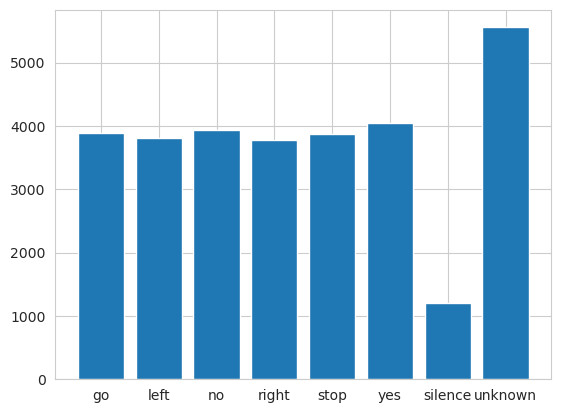

In [8]:
unique, counts = np.unique(labels, return_counts=True)

plt.bar(commands, counts)

# Split data into data and labels

In [9]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 21048
Validation data length: 3006
Test data length: 6015
Full dataset length: 30069


# Normalize PCM audio vectors

In [10]:
train_data.dtype

dtype('float32')

In [11]:
print(f"[Train dataset] Max amplitude before normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude before normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude before normalization: {np.max(np.abs(test_data))}")

train_data_max = np.max(np.abs(train_data))
valid_data_max = np.max(np.abs(val_data))
test_data_max = np.max(np.abs(test_data))

for i in range(len(train_data)):
    train_data[i] /= train_data_max
    print(i)
    
for i in range(len(val_data)):
    val_data[i] /= valid_data_max
    print(i)
    
for i in range(len(test_data)):
    test_data[i] /= test_data_max
    print(i)

print(f"[Train dataset] Max amplitude after normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude after normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude after normalization: {np.max(np.abs(test_data))}")

[Train dataset] Max amplitude before normalization: 49288.7265625
[Valid dataset] Max amplitude before normalization: 46418.1171875
[Test dataset] Max amplitude before normalization: 52985.34765625
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


# Spectrograms

In [12]:
def get_spectrogram(pcm):
    D = librosa.stft(pcm, n_fft=256, hop_length=128, window='hann')
    return np.abs(D)

In [13]:
train_data = np.array([get_spectrogram(x) for x in train_data])
valid_data = np.array([get_spectrogram(x) for x in val_data])
test_data = np.array([get_spectrogram(x) for x in test_data])

In [14]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

# Model

In [15]:

# Update input shape
input_shape = train_data[0].shape  # This will now be (129, 126, 1)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(train_data)

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(128, 3, activation='leaky_relu'),
    layers.Conv2D(64, 3, activation='leaky_relu'),
    layers.Conv2D(32, 3, activation='leaky_relu'),
    layers.Conv2D(16, 1, activation='leaky_relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

model.summary()

Input shape: (129, 63, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       173,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,867 (1.04 MB)

 Trainable params: 271,864 (1.04 MB)

 Non-trainable params: 3 (16.00 B)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [17]:
train_labels = train_labels.astype(np.float32)
valid_labels = val_labels.astype(np.float32)

In [18]:
EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    batch_size=512
)

Epoch 1/100


/home/vistek/anaconda3/envs/deep_learning/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1735491864.397343   53356 service.cc:146] XLA service 0x7cd394015a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735491864.397376   53356 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-29 18:04:24.436192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-29 18:04:24.550458: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-29 18:04:24.913170: I external/local_xla/

11/42 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1640 - loss: 2.0484

I0000 00:00:1735491868.766599   53356 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.2266 - loss: 1.9447 - val_accuracy: 0.4880 - val_loss: 1.4710
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4701 - loss: 1.4316 - val_accuracy: 0.6494 - val_loss: 1.0147
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6280 - loss: 1.0382 - val_accuracy: 0.7226 - val_loss: 0.7963
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7060 - loss: 0.8323 - val_accuracy: 0.7488 - val_loss: 0.7230
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7441 - loss: 0.7233 - val_accuracy: 0.7878 - val_loss: 0.6367
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7719 - loss: 0.6586 - val_accuracy: 0.7994 - val_loss: 0.5985
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7997 - loss: 0.5719 - val_accuracy: 0.8187 - val_loss: 0.5518
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8067 - loss: 0.5554 - val_accuracy: 0.8244 - val_l

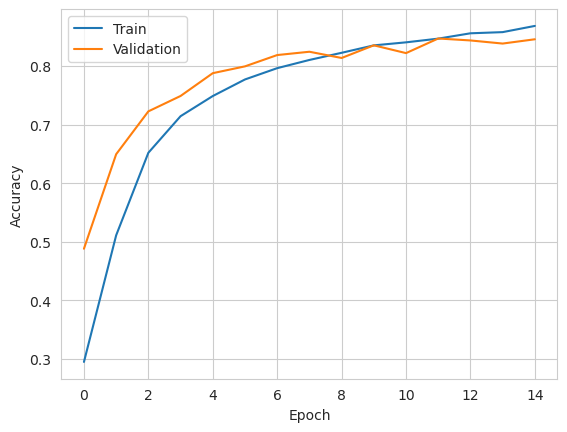

In [19]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

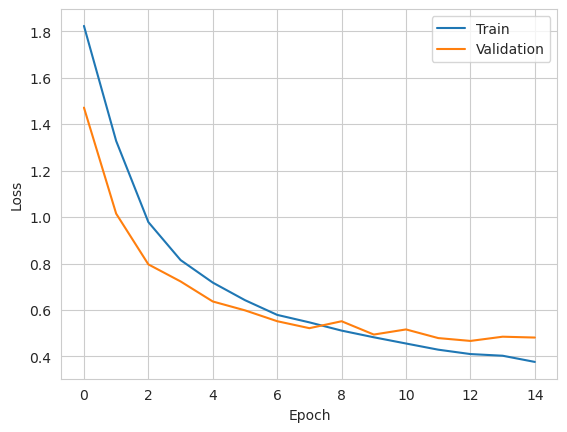

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [21]:
raw_test_data, raw_data_label = next(iter(dataset["test"].take(1)))

TypeError: '_ShuffleDataset' object is not subscriptable

In [115]:
display.Audio(raw_test_data.numpy(), rate=16000)

In [22]:
# Add batch dimension to the first sample of test_data
sample = test_data[0]


img_array = tf.expand_dims(sample, 0)
print(img_array.shape)

prediction = np.argmax(model.predict(img_array), axis=1)
print(f"Prediction: {prediction}")

(1, 129, 63, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Prediction: [5]


In [23]:
results = model.evaluate(test_data, test_labels, batch_size=128)
print("test loss, test acc:", results)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8534 - loss: 0.4365
test loss, test acc: [0.45306310057640076, 0.8498753309249878]


In [24]:
y_pred = np.argmax(model.predict(test_data), axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [25]:
import seaborn as sns

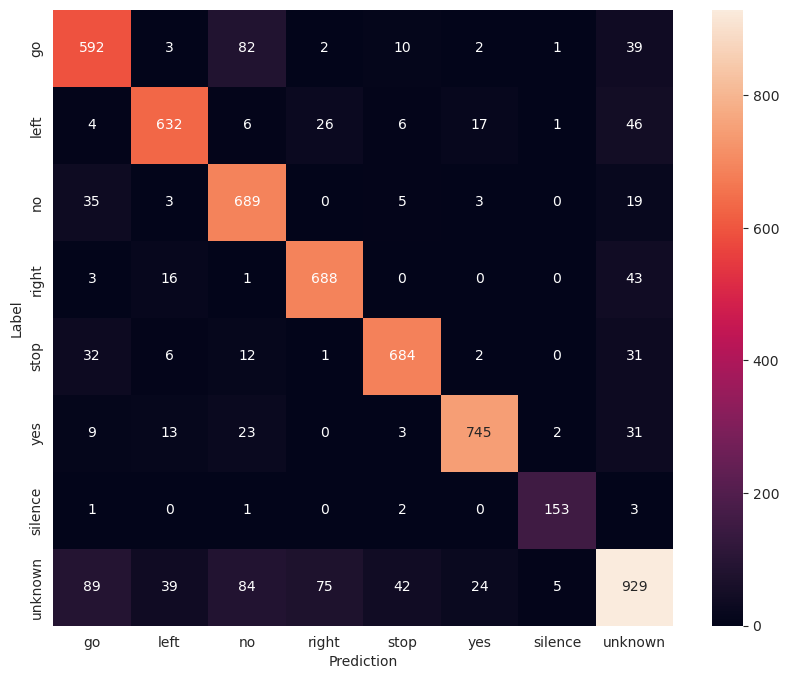

In [26]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [29]:
model.save("/home/vistek/TRA_PROJ/NET_prototype/tra_prototype_model.keras")